# XGBoost与Python图解

ML模型能够被应用的两个重要因素：
- 使用有效的（统计）模型来捕获复杂的**数据依赖性**。
- **可伸缩**的学习系统，该系统可从大型数据集中学习感兴趣的模型。

## 1 背景知识
假设有一组总数为$n$，特征数为$m$的数据，$\mathcal{D}=\left\{\left(\mathbf{x}_{i}, y_{i}\right)\right\}\left(|\mathcal{D}|=n, \mathbf{x}_{i} \in \mathbb{R}^{m}, y_{i} \in \mathbb{R}\right)$，用一个$K$次加法的树集成模型来逼近标签：

$$\hat{y}_{i}=\sum_{k=1}^{K} f_{k}\left(x_{i}\right), \quad f_{k} \in \mathcal{F}$$

其中$\mathcal{F}=\left\{f(\mathbf{x})=w_{q(\mathbf{x})}\right\}\left(q: \mathbb{R}^{m} \rightarrow T, w \in \mathbb{R}^{T}\right)$，称作回归树空间（CART），$T$是每个树（共$K$个树）的叶子结点数量，$q$将一个样本映射到每棵树对应的叶子位置上，$w$就是这个叶子上的值（权重）。

举个例子，如下图所示。有一组数据，$n=5$（5个人），$m=3$（年龄、性别和电脑）；树集成模型$K=2$（有两棵树），第二棵树的$q$将5个样本分别映射到2个叶子结点，这两个叶子结点的$w$分别为0.9和-0.9。

![image.png-74.8kB](http://static.zybuluo.com/AustinMxnet/qegdiq300o2po61f9kbqviy1/image.png)

这样，这组数集成模型就可以预测一个人是否喜欢电脑（或者预测喜欢的程度），输入一个男孩的特征得到预测结果为2.9（两棵树对应结点值相加）。

**下面的CART和GBDT两个小节如果没学过，可以先略过，不影响后面的内容！**

### 1.1 CART回归树
CART回归树是假设树为二叉树，通过不断将特征进行分裂。比如当前树结点是基于第$j$个特征值进行分裂的，设该特征值小于$s$的样本划分为左子树，大于$s$的样本划分为右子树。

$$R_{1}(j, s)=\left\{x | x^{(j)} \leq s\right\}\quad \text{and}\quad R_{2}(j, s)=\left\{x | x^{(j)}>s\right\}$$

而CART回归树实质上就是在该特征维度对样本空间进行划分，而这种空间划分的优化是一种NP难问题，因此，在决策树模型中是使用启发式方法解决。典型CART回归树产生的目标函数为：

$$\sum_{x_{i} \in R_{m}}\left(y_{i}-f\left(x_{i}\right)\right)^{2}$$

因此，当我们为了求解最优的切分特征$j$和最优的切分点$s$，就转化为求解这么一个目标函数：

$$\min _{j, s}\left[\min _{c_{1}} \sum_{x_{i} \in R_{1}(j, s)}\left(y_{i}-c_{1}\right)^{2}+\min _{c_{2}} \sum_{x_{i} \in R_{2}(j, s)}\left(y_{i}-c_{2}\right)^{2}\right]$$

所以我们只要遍历所有特征的所有切分点，就能找到最优的切分特征和切分点，最终得到一颗回归树（对，就一棵树，所以缺点也很明显，后面的特征只能基于前面特征切分的结果再次切分）。

### 1.2 GBDT梯度提升树
和XGboost最接近的就是GBDT，其采用加法模型与前向分布算法，以决策树为基学习器，多个决策树集成提成的方法：
$$f_{M}(x)=T\left(x ; \Theta_{m}\right)$$

$M$为树的个数，$T$是决策树。GBDT采用平方误差作为损失函数，选取特征划切分点的依据是最小化每个结点的损失函数，每一棵新树学习标签和之前所有决策树结果和的残差：

$$\begin{array}{l}
f_{0}(x)=0 \\
f_{m}(x)=f_{m-1}(x)+T\left(x ; \Theta_{m}\right), m=1,2, \cdots M \\
f_{M}(x)=\sum_{m=1}^{M} T\left(x ; \Theta_{m}\right)
\end{array}$$

$$\widehat{\Theta}_{m}=\arg \min _{\Theta_{m}} \sum_{i=1}^{N} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+T\left(x_{i} ; \Theta_{m}\right)\right)$$

采用平方误差损失函数时，损失函数变为：

$$\begin{array}{l}
L\left(y, f_{m-1}(x)+T\left(x ; \Theta_{m}\right)\right) \\
=\left(y-f_{m-1}(x)-T\left(x ; \Theta_{m}\right)\right)^{2} \\
=\left(r-T\left(x ; \Theta_{m}\right)\right)^{2}
\end{array}$$

其中$r$为之前模型拟合数据的残差，是当前优化目标。单独的使用GBDT模型，容易出现过拟合（因为先被选取分裂的特征权重较大，留给后面特征拟合的是相对比较小的残差），在实际应用中往往使用GBDT＋LR的方式做模型训练（这也是XGBoost改进之一）。

> GBDT/XGBoost VS. 随机森林：
> - GBDT和XGBoost是逐个添加树，逐个提升，是一种Boosting算法，每一次树的添加必然会提升预测结果，最终得到最精确的预测结果。
> - 随机森林是随机生成多个树，多个树共同进行决策，是一种Bagging算法。

## 2 XGBoost
XGBoost优化的目标如下：

$$Obj = \sum_i^n(l(y_i, \hat{y}_i))+\sum_k^K\Omega\left(f_{k}\right)$$

$n$为样本数量，$y_i$为第$i$个样本的标签，$\hat{y}_i$为预测值，$K$为树的棵数，$\Omega(f_k)$为第$k$棵树的复杂度，$l$为损失函数。

> - 损失函数$l$用于描述模型拟合数据的程度
> - 正则向$\Omega$用于控制模型的复杂度

损失函数$l$可以根据功能定义，回归可以MSE即$\frac{1}{n}\sum_i^n(y_i-\hat{y_i})^2$，分类可以用逻辑回归（见附录）。

正则向则是让每棵树中叶子结点数$T$和每个叶子大小$w_j$的平方和都尽可能小，这样就控制了每棵树的叶子结点树、叶子结点绝对值、还有树的数量不能过大。让谁更小取决于超参数$\lambda$和$\gamma$的大小。

$$\Omega\left(f\right)=\gamma T+\frac{1}{2} \lambda \sum_{j=1}^{T} w_{j}^{2}$$

> 如果没有正则向，那么目标函数就变成了传统的gradient tree boosting。

### 2.1 Additive/Heuristic Training
**重点：**由于目标函数中包含不确定函数$f_k$，所以不能用SGD在几何空间内优化（适用于优化数值向量），我们就要用additive/heuristic training。从常数0开始，每一轮训练保留原来的模型不变，尝试加入一个新的函数$f(x)$到模型中：

$\hat{y}_{i}^{(0)}=0$

$\hat{y}_{i}^{(1)}=f_{1}\left(x_{i}\right)=\hat{y}_{i}^{(0)}+f_{1}\left(x_{i}\right)$

...

$\hat{y}_{i}^{(t)}=\sum_{k=1}^{t} f_{k}\left(x_{i}\right)=\hat{y}_{i}^{(t-1)}+f_{t}\left(x_{i}\right)$

其中，$\hat{y}_{i}^{(t-1)}$是上一次模型的预测结果，目标就是每轮找到一个新的函数$f_t$（第$t$棵树）使得下面的目标函数最小：

$$\begin{aligned}
\mathcal{L}^{(t)} &= \sum_{i=1}^{n} l\left(y_{i}, \hat{y}_{i}^{(t)}\right) + \sum_{i=1}^t\Omega\left(f_{i}\right)\\
&= \sum_{i=1}^{n} l\left(y_{i}, \hat{y}_{i}^{(t-1)}+f_{t}\left(\mathbf{x}_{i}\right)\right)+\Omega\left(f_{t}\right) + \text{constant}\end{aligned}$$

> $t$指的是第几轮训练，个人理解应该等于树的棵树$k$

### 2.2 寻找最优结点值
#### 2.2.1 损失函数的二阶泰勒展开式
现在问题变成了怎么找到一个合适的$f$呢？先看下泰勒公式的二阶展开式：

$$f(x) \simeq \frac{f\left(x_{0}\right)}{0 !}+\frac{f^{\prime}\left(x_{0}\right)}{1 !}\left(x-x_{0}\right)+\frac{f^{\prime \prime}\left(x_{0}\right)}{2 !}\left(x-x_{0}\right)^{2}$$

将$x$用$x+\Delta x$替换：

$$f(x+\Delta x) \simeq f\left(x_{0}\right) + f^{\prime}\left(x_{0}\right)\left(x+\Delta x-x_{0}\right) + \frac{f^{\prime \prime}\left(x_{0}\right)}{2}\left(x+\Delta x-x_{0}\right)^{2}$$

这里我们这样理解下，假设已经知道了$x$在$k$处$f(k)$的值，那么用上面的公式求$x$在$x=k+\Delta x$处的值：

$$f(k+\Delta x) \simeq f\left(x_{0}\right) + f^{\prime}\left(x_{0}\right)\left(k+\Delta x-x_{0}\right) + \frac{f^{\prime \prime}\left(x_{0}\right)}{2}\left(k+\Delta x-x_{0}\right)^{2}$$

进一步，将$x_0$设为$k$：

$$f(k+\Delta x) \simeq f(k)+f^{\prime}(k) \Delta x+\frac{1}{2} f^{\prime \prime}(k) \Delta x^{2}$$

**重点来了！！！**
**损失函数$l\left(y_{i}, \hat{y}_{i}^{(t-1)}+f_{t}\left(\mathbf{x}_{i}\right)\right)$中的$\hat{y}_i^{t-1}$相当于已知的$k$，本轮要增加的$f_t(x_i)$就是$\Delta x$，只要损失函数$l$有一阶和二阶导数，就可以得到：**

$$\begin{aligned}
\mathcal{L}^{(t)} &=\sum_{i=1}^{n} l\left(y_{i}, \hat{y}_{i}^{(t-1)}+f_{t}\left(\mathbf{x}_{i}\right)\right)+\Omega\left(f_{t}\right)+\mathrm{constant}\\
&= \sum_{i=1}^{n} \left[l\left(y_{i}, \hat{y}_{i}^{(t-1)}\right)+g_{i} f_{t}\left(x_{i}\right)+\frac{1}{2} h_{i} f_{t}^{2}\left(x_{i}\right)\right] +\Omega\left(f_{t}\right)+\mathrm{constant}
\end{aligned}$$

其中$g_{i}=\partial_{\hat{y}^{(t-1)}} l\left(y_{i}, \hat{y}^{(t-1)}\right)$，$h_{i}=\partial_{\hat{y}^{(t-1)}}^2 l\left(y_{i}, \hat{y}^{(t-1)}\right)$。

以Square Loss $(y-\hat{y})^2$为例：

$g_{i}=\partial_{\hat{y}^{(t-1)}}\left(\hat{y}^{(t-1)}-y_{i}\right)^{2}=2\left(\hat{y}^{(t-1)}-y_{i}\right)$
$h_{i}=\partial_{\hat{y}^{(t-1)}}^{2}\left(y_{i}-\hat{y}^{(t-1)}\right)^{2}=2$

这里补充一下，对于$f(x)=(x-a)^2$来说，二阶泰勒展开式是无损的，因为其三阶之后的导数都为0，可以做个试验：

$$\begin{aligned}
f(x) &= x^2\\
&= f(x_0)+f^{\prime}(x_0)(x-x_0) + \frac{1}{2} f^{\prime \prime}(x_0) (x-x_0)^{2}\end{aligned}$$

In [1]:
def Square(x):
    return x**2

def TaylorSquare(x, x0):
    return Square(x0) + 2*x0*(x-x0) + (x-x0)**2

In [2]:
x = 10
print('x = %d:'%x, Square(x), TaylorSquare(x, 0), TaylorSquare(x, 100))

x = -5
print('x = %d:'%x, Square(x), TaylorSquare(x, 0), TaylorSquare(x, 100))

x = 10: 100 100 100
x = -5: 25 25 25


可以看出$f(x) = x^2$的二阶泰勒展开式计算结果没有差异。

#### 2.2.2 二次项极值
整理一下现在的目标函数：

$$\mathcal{L}^{(t)} = \sum_{i=1}^{n} \left[l\left(y_{i}, \hat{y}_{i}^{(t-1)}\right)+g_{i} f_{t}\left(x_{i}\right)+\frac{1}{2} h_{i} f_{t}^{2}\left(x_{i}\right)\right] +\Omega\left(f_{t}\right)+\mathrm{constant}$$

将不影响结果的常数项除去：

$$\mathcal{L}^{(t)} = \sum_{i=1}^{n} \left[ g_{i} f_{t}\left(x_{i}\right)+\frac{1}{2} h_{i} f_{t}^{2}\left(x_{i}\right)\right] +\Omega\left(f_{t}\right)$$

如果单独看$g_{i} f_{t}\left(x_{i}\right)+\frac{1}{2} h_{i} f_{t}^{2}\left(x_{i}\right)$，就是一个$ax^2+bx+c$，很容易求出极值$x^{*}=-\frac{b}{2 a}$时，$y^{*}=\frac{4 a c-b^{2}}{4 a}$，**当a>0时候为极小值！**

但是现在还不能这么做，因为有$\Omega(f_t)=\gamma T+\frac{1}{2} \lambda \sum_{j=1}^{T} w_{j}^{2}$的存在，为了约束树的复杂度，由两部分组成：

- 叶子结点的数量$T$
- 叶子结点值$L2$范数 

如下图中这棵树的的$\Omega = \gamma 3+\frac{1}{2} \lambda (4+0.01+1)$。
![image.png-83.6kB](http://static.zybuluo.com/AustinMxnet/n0pdf3dlnxvq86xbt3yunwnp/image.png)

可以看出$\mathcal{L}^{(t)}$后半部分$\Omega$只和两个变量（$T, w_j$）有关系，如果前半部分也能变成只和这两个变量相关就好了。于是我们定义$I_{j}=\left\{i | q\left(x_{i}\right)=j\right\}$（回忆一下文章最开始“$q$将一个样本映射到每棵树对应的叶子位置上”），也就是$n$个样本$x$被$q$全部映射到这棵树$T$个节点上，即：

$$\sum_i^nf(x_i)=\sum_j^T\left(\sum_{i\in I_j}w_j\right)$$

代入目标函数：

$$\begin{aligned} Obj^{(t)} & \simeq \sum_{i=1}^{n}\left[g_{i} f_{t}\left(x_{i}\right)+\frac{1}{2} h_{i} f_{t}^{2}\left(x_{i}\right)\right]+\Omega\left(f_{t}\right) \\ &=\sum_{i=1}^{n}\left[g_{i} w_{q\left(x_{i}\right)}+\frac{1}{2} h_{i} w_{q\left(x_{i}\right)}^{2}\right]+\gamma T+\lambda \frac{1}{2} \sum_{j=1}^{T} w_{j}^{2} \\ &=\sum_{j=1}^{T}\left[\left(\sum_{i \in I_{j}} g_{i}\right) w_{j}+\frac{1}{2}\left(\sum_{i \in I_{j}} h_{i}+\lambda\right) w_{j}^{2}\right]+\gamma T \end{aligned}$$

定义$G_{j}=\sum_{i \in I_{j}} g_{i} H_{j}=\sum_{i \in I_{j}} h_{i}$，继续简化：

$$Obj^{(t)} = \sum_{j=1}^{T}\left[G_{j} w_{j}+\frac{1}{2}\left(H_{j}+\lambda\right) w_{j}^{2}\right]+\gamma T$$

我们想利用如下公式求得$w_{j}^{*}$：

$$\operatorname{argmin}_{x} G x+\frac{1}{2} H x^{2}=-\frac{G}{H}, H>0 \quad \min _{x} G x+\frac{1}{2} H x^{2}=-\frac{1}{2} \frac{G^{2}}{H}$$

$$w_{j}^{*}=-\frac{G_{j}}{H_{j}+\lambda} \quad O b j=-\frac{1}{2} \sum_{j=1}^{T} \frac{G_{j}^{2}}{H_{j}+\lambda}+\gamma T$$

现在我们得到了每个结点的权重值$w_j^*$，**但是有个问题：树的结构没有确定，于是$T, H_j, G_j$都是不确定的！但是树的结构是分裂次数以及如何分裂决定的，我们的目标从最小化目标函数回归到找到最优树的结构。**

#### 2.2.3 最优分裂
树的结构是有无限种可能的，我们从第一个结点分裂开始使用贪心算法，遍历所有特征的所有划分点，选出增益$
\frac{G_{j}}{H_{j}+\lambda}$最大的点，当然为了限制增长，可以设置分裂的增益阈值，还有最大深度（max_depth），另外还有最小样本权重和（min_child_weight，分裂后任一个叶子结点值不能低于这个值），防止一个叶子结点包含的特征数量太少导致树分的太细，也是过拟合的一种措施。

一个叶子结点分裂为左右两个子叶子结点，原叶子结点中的样本集将根据该结点的判断规则分散到左右两个叶子结点中，计算这次分裂是否会给损失函数带来增益，增益的定义如下：

$$\operatorname{Gain}=\frac{1}{2}\left[\frac{G_{L}^{2}}{H_{L}+\lambda}+\frac{G_{R}^{2}}{H_{R}+\lambda}-\frac{\left(G_{L}+G_{R}\right)^{2}}{H_{L}+H_{R}+\lambda}\right]-\gamma$$

Gain公式中减去了不分裂情况下的增益，并且引入$\gamma$惩罚新增一个叶子结点带来的复杂度。当新引入的一次分裂所带来的增益Gain<0时，放弃当前的分裂。这是训练损失和模型结构复杂度的博弈过程。

所以一个叶子结点分裂就是：遍历$n$样本中所有特征的不重复点（不同样本可能存在相同的特征，例如A和B年龄相同），然后选出增益最大的点。

例如我们对下面5个样本进行分裂，分别计算不同特征分别在不同位置处的增益，例如对年龄age在a处分裂，age小于a的放左边，大于等于a的放右边，然后分别计算出$G_L, G_R, H_L, H_R$并得到Gain。

![image.png-60.2kB](http://static.zybuluo.com/AustinMxnet/3z4afkfweipe0j1qbg9wwugk/image.png)

> 注意：计算$G$和$H$时，$g_i$和$h_i$（只和上轮结果、标签值有关）是不用重复计算的，只需计算一次就行。可以参加下面的实验章节。

由于贪心算法每次进行分裂尝试都要遍历一遍全部候选分割点，也叫做全局扫描法。当数据量过大导致内存无法一次载入或者在分布式情况下，贪心算法的效率就会变得很低，全局扫描法不再适用。基于此，XGBoost提出了一系列加快寻找最佳分裂点的方案：

- 特征预排序+缓存：XGBoost在训练之前，预先对每个特征按照特征值大小进行排序，然后保存为block结构，后面的迭代中会重复地使用这个结构，使计算量大大减小。
- 分位点近似法：对每个特征按照特征值排序后，采用类似分位点选取的方式，仅仅选出常数个特征值作为该特征的候选分割点，在寻找该特征的最佳分割点时，从候选分割点中选出最优的一个。
- 并行查找：由于各个特性已预先存储为block结构，XGBoost支持利用多个线程并行地计算每个特征的最佳分割点，这不仅大大提升了结点的分裂速度，也极利于大规模训练集的适应性扩展。

至此，XGBoost主要思想全部讲完，还有一些训练上的细节留在下一章。

## 3 深入思考
这部分内容是对XGboos深入思考，大多是训练和优化中的一些细节，决定了XGBoost能否真正被广泛应用。由于精力有限，摘抄了一些其他博客的内容，可以看本文最后“深入分析”推荐的文章。

### 3.1 Shrinkage and Column Subsampling
XGBoost还提出了两种防止过拟合的方法：Shrinkage and Column Subsampling。Shrinkage方法就是在每次迭代中对树的每个叶子结点的分数乘上一个缩减权重η，这可以使得每一棵树的影响力不会太大，留下更大的空间给后面生成的树去优化模型。Column Subsampling类似于随机森林中的选取部分特征进行建树。其可分为两种，一种是按层随机采样，在对同一层内每个结点分裂之前，先随机选择一部分特征，然后只需要遍历这部分的特征，来确定最优的分割点。另一种是随机选择特征，则建树前随机选择一部分特征然后分裂就只遍历这些特征。一般情况下前者效果更好。

### 3.2 近似算法
对于连续型特征值，当样本数量非常大，该特征取值过多时，遍历所有取值会花费很多时间，且容易过拟合。因此XGBoost思想是对特征进行分桶，即找到l个划分点，将位于相邻分位点之间的样本分在一个桶中。在遍历该特征的时候，只需要遍历各个分位点，从而计算最优划分。从算法伪代码中该流程还可以分为两种，全局的近似是在新生成一棵树之前就对各个特征计算分位点并划分样本，之后在每次分裂过程中都采用近似划分，而局部近似就是在具体的某一次分裂节点的过程中采用近似算法。

### 3.3 针对稀疏数据的算法（缺失值处理）

当样本的第$i$个特征值缺失时，无法利用该特征进行划分时，XGBoost的想法是将该样本分别划分到左结点和右结点，然后计算其增益，哪个大就划分到哪边。


### 3.4 XGBoost的优点

- 传统GBDT以CART作为基分类器，XGBoost还支持线性分类器，这个时候XGBoost相当于带L1和L2正则化项的逻辑斯蒂回归（分类问题）或者线性回归（回归问题）。

- 传统GBDT在优化时只用到一阶导数信息，XGBoost则对代价函数进行了二阶泰勒展开，同时用到了一阶和二阶导数。顺便提一下，XGBoost工具支持自定义代价函数，只要函数可一阶和二阶求导。

- XGBoost在代价函数里加入了正则项，用于控制模型的复杂度。正则项里包含了树的叶子节点个数、每个叶子节点上输出的score的L2模的平方和。从Bias-variance tradeoff角度来讲，正则项降低了模型的variance，使学习出来的模型更加简单，防止过拟合，这也是XGBoost优于传统GBDT的一个特性。

- Shrinkage（缩减），相当于学习速率（XGBoost中的eta）。XGBoost在进行完一次迭代后，会将叶子节点的权重乘上该系数，主要是为了削弱每棵树的影响，让后面有更大的学习空间。实际应用中，一般把eta设置得小一点，然后迭代次数设置得大一点。（补充：传统GBDT的实现也有学习速率）

- 列抽样（column subsampling）即特征抽样。XGBoost借鉴了随机森林的做法，支持列抽样，不仅能降低过拟合，还能减少计算，这也是XGBoost异于传统gbdt的一个特性。

- 对缺失值的处理。对于特征的值有缺失的样本，XGBoost可以自动学习出它的分裂方向。

- XGBoost工具支持并行。boosting不是一种串行的结构吗?怎么并行的？注意XGBoost的并行不是tree粒度的并行，XGBoost也是一次迭代完才能进行下一次迭代的（第t次迭代的代价函数里包含了前面t-1次迭代的预测值）。XGBoost的并行是在特征粒度上的。我们知道，决策树的学习最耗时的一个步骤就是对特征的值进行排序（因为要确定最佳分割点），XGBoost在训练之前，预先对数据进行了排序，然后保存为block结构，后面的迭代中重复地使用这个结构，大大减小计算量。这个block结构也使得并行成为了可能，在进行节点的分裂时，需要计算每个特征的增益，最终选增益最大的那个特征去做分裂，那么各个特征的增益计算就可以开多线程进行。

- 可并行的近似直方图算法。树节点在进行分裂时，我们需要计算每个特征的每个分割点对应的增益，即用贪心法枚举所有可能的分割点。当数据无法一次载入内存或者在分布式情况下，贪心算法效率就会变得很低，所以XGBoost还提出了一种可并行的近似直方图算法，用于高效地生成候选的分割点。


### 3.5 One-hot encoding
在实际的机器学习的应用任务中，对于类别有序的类别型变量，比如 age 等，当成数值型变量处理可以的。特征有时候并不总是连续值，有可能是一些分类值，如性别可分为“male”和“female”。在机器学习任务中，对于这样的特征，通常我们需要对其进行特征数字化，比如有如下三个特征属性：

- 性别：[“male”，”female”]
- 地区：[“Europe”，”US”，”Asia”]
- 浏览器：[“Firefox”，”Chrome”，”Safari”，”Internet Explorer”]

对于某一个样本，如[“male”，”US”，”Internet Explorer”]，我们需要将这个分类值的特征数字化，最直接的方法，我们可以采用序列化的方式：[0,1,3]。但是，即使转化为数字表示后，上述数据也不能直接用在我们的分类器中。因为，分类器往往默认数据是连续的，并且是有序的。按照上述的表示，数字并不是有序的，而是随机分配的。这样的特征处理并不能直接放入机器学习算法中。

为了解决上述问题，其中一种可能的解决方法是采用独热编码（One-Hot Encoding）。独热编码，又称为一位有效编码。其方法是使用N位状态寄存器来对N个状态进行编码，每个状态都由他独立的寄存器位，并且在任意时候，其中只有一位有效。可以这样理解，对于每一个特征，如果它有m个可能值，那么经过独热编码后，就变成了m个二元特征。并且，这些特征互斥，每次只有一个激活。因此，数据会变成稀疏的。

对于上述的问题，性别的属性是二维的，同理，地区是三维的，浏览器则是四维的，这样，我们可以采用One-Hot编码的方式对上述的样本“[“male”，”US”，”Internet Explorer”]”编码，“male”则对应着[1，0]，同理“US”对应着[0，1，0]，“Internet Explorer”对应着[0,0,0,1]。则完整的特征数字化的结果为：[1,0,0,1,0,0,0,0,1]。

#### 3.5.1 为什么能使用One-Hot Encoding？
使用one-hot编码，将离散特征的取值扩展到了欧式空间，离散特征的某个取值就对应欧式空间的某个点。在回归，分类，聚类等机器学习算法中，特征之间距离的计算或相似度的计算是非常重要的，而我们常用的距离或相似度的计算都是在欧式空间的相似度计算，计算余弦相似性，也是基于的欧式空间。
将离散型特征使用one-hot编码，可以会让特征之间的距离计算更加合理。比如，有一个离散型特征，代表工作类型，该离散型特征，共有三个取值，不使用one-hot编码，计算出来的特征的距离是不合理。那如果使用one-hot编码，显得更合理。

#### 3.5.2 独热编码优缺点
优点：独热编码解决了分类器不好处理属性数据的问题，在一定程度上也起到了扩充特征的作用。它的值只有0和1，不同的类型存储在垂直的空间。
缺点：当类别的数量很多时，特征空间会变得非常大。在这种情况下，一般可以用PCA（主成分分析）来减少维度。而且One-Hot Encoding+PCA这种组合在实际中也非常有用。

#### 3.5.3 One-Hot Encoding的使用场景
独热编码用来解决类别型数据的离散值问题。将离散型特征进行one-hot编码的作用，是为了让距离计算更合理，但如果特征是离散的，并且不用one-hot编码就可以很合理的计算出距离，那么就没必要进行one-hot编码，比如，该离散特征共有1000个取值，我们分成两组，分别是400和600,两个小组之间的距离有合适的定义，组内的距离也有合适的定义，那就没必要用one-hot 编码。
基于树的方法是不需要进行特征的归一化，例如随机森林，bagging 和 boosting等。对于决策树来说，one-hot的本质是增加树的深度，决策树是没有特征大小的概念的，只有特征处于他分布的哪一部分的概念。

### 3.6 为什么不适合处理高维稀疏特征

本质XGBoost是一个贪婪算法 要从候选特征集合中选择一个使分裂后信息增益最大的特征来分裂。这就是他不适合处理稀疏数据的原因 ，会产生很多的子树，训练特别慢。同时id分裂的泛化性弱。这个时候LR就会比xgb强 ，但是LR没办法自动对特征进行组合。

### 3.7 XGBoost计算特征权重的方式有哪些 ？

一共五种，常用Gain：

- ‘weight’：权重形式，表示在所有树中，一个特征在分裂节点时被使用了多少次。

- ‘gain’：（平均）增益形式，表示在所有树中，一个特征作为分裂节点存在时，带来的增益的平均值。

- ‘cover’：（平均）覆盖度，表示在所有树中，一个特征作为分裂节点存在时，覆盖的样本数量的平均值。

- ‘total_gain’：相对于’gain’，这里表示的是带来的总增益大小。

- ‘total_cover’：相对于’cover’，这里表示的是覆盖的总样本数量。

## 4 动手实践

XGBoost优化的目标如下：

$Obj = \sum_i^n(l(y_i, \hat{y}_i))+\sum_k^K\Omega\left(f_{k}\right)$

$n$为样本数量，$y_i$为第$i$个样本的标签，$\hat{y}_i$为预测值，$K$为树的棵数，$\Omega(f_k)$为第$k$棵树的复杂度，$l$为损失函数。

> - 损失函数$l$用于描述模型拟合数据的程度
> - 正则想$\Omega$用于控制模型的复杂度

其中$\hat{y}_{i}=\sum_{k=1}^{K} f_{k}\left(x_{i}\right), \quad f_{k} \in \mathcal{F}$

**e.g. 有一组$n=15$的样本，每个样本有2个特征（$x1, x2$）：**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display
from graphviz import Digraph

In [4]:
X = np.array([[1, -5], [2, 5], [3, -2], [1, 2], [2, 0], [6, -5],
              [7, 5], [6, -2], [7, 2], [6, 0], [8, -5], [9, 5],
              [10, -2], [8, 2], [9, 0]]).transpose()

Y = np.array([[0], [0], [1], [1], [1], [1], [1], [0], [0],
              [1], [1], [1], [0], [0], [1]]).reshape(-1)

pd.DataFrame(np.vstack([X, Y]), dtype='int', index=['x1', 'x2', 'y'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
x1,1,2,3,1,2,6,7,6,7,6,8,9,10,8,9
x2,-5,5,-2,2,0,-5,5,-2,2,0,-5,5,-2,2,0
y,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1


我们的目标就是要让模型对15组数据预测的$\hat{y}$和标签$y$尽可能的一致，由于是二分类问题，我们可以选Logistic Regression作为损失函数：

$L\left(y_{i}, \hat{y}_{i}\right)=y_{i} \ln \left(1+e^{-\hat{y}_{i}}\right)+\left(1-y_{i}\right) \ln \left(1+e^{\hat{y}_{i}}\right)$

$g_{i}=\partial_{\hat{y}_{i}^{(t-1)}} l\left(y_{i}, \hat{y}_{i}^{(t-1)}\right) = \frac{1}{1+e^{-\hat{y}_{i}}}-y_{i}$

$h_{i}=\partial_{\hat{y}_{i}^{(t-1)}}^{2} l\left(y_{i}, \hat{y}_{i}^{(t-1)}\right)=y_{i, \text {pred}} *\left(1-y_{i, \text {pred}}\right); y_{i, \text {pred}}=\frac{1}{1+e^{-\hat{y}_{i}}}$

In [5]:
Yhi = np.zeros_like(Y)

def ComputeGH(Yhi, Y):
    t = 1/(1+np.exp(-Yhi))
    G = t - Y
    H = t*(1-t)
    return G, H

G, H = ComputeGH(Yhi, Y)

pd.DataFrame(np.vstack([Yhi, Y, G, H]),
             dtype='float', index=['y_hi', 'y', 'g', 'h'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
y_hi,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
y,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00
g,0.50,0.50,-0.50,-0.50,-0.50,-0.50,-0.50,0.50,0.50,-0.50,-0.50,-0.50,0.50,0.50,-0.50
h,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


$\operatorname{Gain}=\frac{1}{2}\left[\frac{G_{L}^{2}}{H_{L}+\lambda}+\frac{G_{R}^{2}}{H_{R}+\lambda}-\frac{\left(G_{L}+G_{R}\right)^{2}}{H_{L}+H_{R}+\lambda}\right]-\gamma$

$G_L = \sum_{i\in I_l} g_i$  
$G_R = \sum_{i\in I_r} g_r$

首先求出特征$x1$在各个值下的gain（这里我们设$\lambda=1,\gamma=0$）：

In [6]:
def ComputeGain(G, H, Xc, lmd=1, gma=0., print_msg=False):
    _Xu = np.sort(np.unique(Xc))
    _gains = []
    for x in _Xu:
        GL = np.sum(G[Xc < x])
        GR = np.sum(G[Xc >= x])
        HL = np.sum(H[Xc < x])
        HR = np.sum(H[Xc >= x])

        gain = (GL**2/(HL+lmd) + GR**2/(HR+lmd) -
                (GL+GR)**2/(HL+HR+lmd))/2 - gma
        if print_msg:
            print("x=%.2f, GL=%.2f, GR=%.2f, HL=%.2f, HR=%.2f)" %
                  (x, GL, GR, HL, HR))
        _gains.append(gain)

    return np.array(_gains), _Xu


def GSDataFrame(gains, splits):
    """以DataFrame格式输出gains、split points，并打上'max'标签
    """
    col = ['-']*len(gains)
    col[np.argmax(gains)] = 'max'
    df = pd.DataFrame(np.round(np.vstack([splits, gains]), 3),
                      dtype='float', index=['split point', 'gain'], columns=col)
    return df


XC1_gains, X1u = ComputeGain(G, H, X[0,:])

print('gains of x1:')
display(GSDataFrame(XC1_gains, X1u))

gains of x1:


,-,-,-,-,-,-,-,max
split point,1.0,2.000,3.000,6.000,7.000,8.000,9.00,10.000
gain,0.0,0.028,0.063,-0.038,-0.025,-0.038,-0.04,0.308


In [7]:
%%script false --no-raise-error
class Node():
    def __init__(self):
        self.h = []
        self.g = []

    def info():

首先求出特征$x2$在各个值下的增益gain：

In [8]:
XC2_gains, X2u = ComputeGain(G, H, X[1,:])

print('gains of x2:')
display(GSDataFrame(XC2_gains, X2u))

gains of x2:


,-,-,max,-,-
split point,-5.0,-2.00,0.000,2.000,5.00
gain,0.0,-0.04,0.109,0.109,-0.04


### 4.1 第一次分裂
通过计算，$x1<10$时的gain=0.308最大，而$x2<0$或者$x2<2$时gain=0.109最大，由于$x1$的gain更大一些，所以我们以特征$x1$最大gain的位置来分裂：

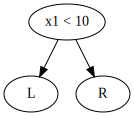

In [9]:
gz = Digraph()
gz.node("t1","x1 < 10")
gz.edge("t1","L")
gz.edge("t1","R")
gz

In [10]:
def Split(X, G, H, pos):
    XGH = np.vstack([X, G, H])
    return XGH[:, pos], XGH[:, ~pos]

sp = X1u[np.argmax(XC1_gains)] # split point
pos = X[0] < sp
L, R = Split(X, G, H, pos)

print('L info:')
display(pd.DataFrame(L, dtype='float', index=['x1L', 'x2L', 'hL', 'gL']))
print('R info:')
display(pd.DataFrame(R, dtype='float', index=['x1R', 'x2R', 'hR', 'gR']))

L info:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
x1L,1.00,2.00,3.00,1.00,2.00,6.00,7.00,6.00,7.00,6.00,8.00,9.00,8.00,9.00
x2L,-5.00,5.00,-2.00,2.00,0.00,-5.00,5.00,-2.00,2.00,0.00,-5.00,5.00,2.00,0.00
hL,0.50,0.50,-0.50,-0.50,-0.50,-0.50,-0.50,0.50,0.50,-0.50,-0.50,-0.50,0.50,-0.50
gL,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


R info:


,0
x1R,10.00
x2R,-2.00
hR,0.50
gR,0.25


### 4.2 第二次分裂

因为树的深度（max_depth）设置为3，这时L和R成为了两个根节点，分别重复上面的步骤：
1. L还有14个样本，所以此结点需要遍历x1L和x2L所有值，选取增益最大的点作为分裂点。
1. R只有1个样本了，此结点不需要分裂了，成为一个叶子节结点，根据公式$w^{*}=-\frac{G_{j}}{H_{j}+\lambda}$计算其结点值（x1R）。

> 注意：
> 1. $h$和$g$之前已经计算过了，所以不需要重复计算。
> 2. 分裂是对样本而言的，所有样本其他特征（x2）也要在对应位置分裂。

In [11]:
Gj, Hj = R[2], R[3]
w = -Gj/(Hj+1)

print('leaf =', w[0])

leaf = -0.4


In [12]:
X1L_gains, X1Lu = ComputeGain(G=L[2], H=L[3], Xc=L[0])

print('gains of x1L at node L:')
display(GSDataFrame(X1L_gains, X1Lu))

gains of x1L at node L:


,-,-,max,-,-,-,-
split point,1.0,2.000,3.000,6.000,7.000,8.000,9.000
gain,0.0,0.056,0.127,-0.043,-0.078,-0.052,0.014


In [13]:
X2L_gains, X2Lu = ComputeGain(G=L[2], H=L[3], Xc=L[1])

print('gains of x2L at node L:')
display(GSDataFrame(X2L_gains, X2Lu))

gains of x2L at node L:


,-,-,-,max,-
split point,-5.0,-2.000,0.000,2.000,5.000
gain,0.0,-0.073,-0.043,0.222,-0.073


计算结果显示应该以$x2<2$分裂。

In [14]:
sp = X2Lu[np.argmax(X2L_gains)] # split point
pos = L[1] < sp
L2, R2 = Split(L[0:2], L[2], L[3], pos)

print('L2 info:')
display(pd.DataFrame(L2, dtype='float', index=['x1L', 'x2L', 'hL', 'gL']))
print('R2 info:')
display(pd.DataFrame(R2, dtype='float', index=['x1R', 'x2R', 'hR', 'gR']))

L2 info:


,0,1,2,3,4,5,6,7
x1L,1.00,3.00,2.00,6.00,6.00,6.00,8.00,9.00
x2L,-5.00,-2.00,0.00,-5.00,-2.00,0.00,-5.00,0.00
hL,0.50,-0.50,-0.50,-0.50,0.50,-0.50,-0.50,-0.50
gL,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


R2 info:


,0,1,2,3,4,5
x1R,2.00,1.00,7.00,7.00,9.00,8.00
x2R,5.00,2.00,5.00,2.00,5.00,2.00
hR,0.50,-0.50,-0.50,0.50,-0.50,0.50
gR,0.25,0.25,0.25,0.25,0.25,0.25


第二次分裂完之后，我们画出第一棵树的情况（最后一层正圆是第三层分裂待求的）：

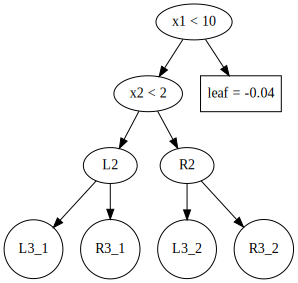

In [15]:
gz = Digraph()
gz.node("t1", "x1 < 10")
gz.node("t2_L", "x2 < 2")
gz.node("t2_R", "leaf = -0.04", shape="box")

gz.edge("t1", "t2_L")
gz.edge("t1", "t2_R")
gz.edge("t2_L", "L2")
gz.edge("t2_L", "R2")

# 第三层分裂待求的
gz.node("t3_L1", "L3_1", shape='circle')
gz.node("t3_R1", "R3_1", shape='circle')
gz.node("t3_L2", "L3_2", shape='circle')
gz.node("t3_R2", "R3_2", shape='circle')
gz.edge("L2", "t3_L1")
gz.edge("L2", "t3_R1")
gz.edge("R2", "t3_L2")
gz.edge("R2", "t3_R2")

gz

### 4.3 第三层分裂
#### 4.3.1 结点L2处的分裂

In [16]:
X1L_gains, X1Lu = ComputeGain(G=L2[2], H=L2[3], Xc=L2[0])

print('gains of x1L at node L2:')
display(GSDataFrame(X1L_gains, X1Lu))

gains of x1L at node L2:


,-,max,-,-,-,-
split point,1.0,2.00,3.000,6.000,8.000,9.000
gain,0.0,0.57,0.133,-0.095,-0.133,-0.158


In [17]:
X1R_gains, X1Ru = ComputeGain(G=L2[2], H=L2[3], Xc=L2[1])

print('gains of x1R at node L2:')
display(GSDataFrame(X1R_gains, X1Ru))

gains of x1R at node L2:


,-,-,max
split point,-5.0,-2.000,0.000
gain,0.0,-0.095,0.032


计算结果显示应该以$x1<2$分裂：

In [18]:
sp = X1Lu[np.argmax(X1L_gains)] # split point
pos = L2[0] < sp
L3_1, R3_1 = Split(L2[0:2], L2[2], L2[3], pos)

print('split point', sp)
print('L3_1 info:')
display(pd.DataFrame(L3_1, dtype='float', index=['x1L', 'x2L', 'hL', 'gL']))
print('R3_1 info:')
display(pd.DataFrame(R3_1, dtype='float', index=['x1R', 'x2R', 'hR', 'gR']))

split point 2.0
L3_1 info:


,0
x1L,1.00
x2L,-5.00
hL,0.50
gL,0.25


R3_1 info:


,0,1,2,3,4,5,6
x1R,3.00,2.00,6.00,6.00,6.00,8.00,9.00
x2R,-2.00,0.00,-5.00,-2.00,0.00,-5.00,0.00
hR,-0.50,-0.50,-0.50,0.50,-0.50,-0.50,-0.50
gR,0.25,0.25,0.25,0.25,0.25,0.25,0.25


因为我们设置的最大深度为3，所以不需要再分裂了，计算叶子结点值：

In [19]:
def CalLeaf(G, H, lmd=1):
    return -np.sum(G)/(np.sum(H)+lmd)

w_L3_1 = CalLeaf(L3_1[2], L3_1[3])
w_R3_1 = CalLeaf(R3_1[2], R3_1[3])

w_L3_1, w_R3_1
print("leaf value: L3_1=%.2f, R3_1=%.2f"%(w_L3_1, w_R3_1))

leaf value: L3_1=-0.40, R3_1=0.91


#### 4.3.2 结点R2处的分裂

In [20]:
X1L_gains, X1Lu = ComputeGain(G=R2[2], H=R2[3], Xc=R2[0], print_msg=False)

print('gains of x1L at node R2:')
display(GSDataFrame(X1L_gains, X1Lu))

gains of x1L at node R2:


,-,max,-,-,-
split point,1.0,2.000,7.0,8.0,9.000
gain,0.0,0.156,0.0,0.0,0.156


In [21]:
X1R_gains, X1Ru = ComputeGain(G=R2[2], H=R2[3], Xc=R2[1])

print('gains of x1R at node R2:')
display(GSDataFrame(X1R_gains, X1Ru))

gains of x1R at node R2:


,-,max
split point,2.0,5.000
gain,0.0,0.143


In [22]:
sp = X1Lu[np.argmax(X1L_gains)] 

sp

2.0

计算结果显示应该以$x1<2$或者$x1<9$分裂：

In [23]:
# sp = X1Lu[np.argmax(X1L_gains)] # split point
sp = 9
pos = R2[0] < sp
L3_2, R3_2 = Split(R2[0:2], R2[2], R2[3], pos)

print('split point', sp)
print('L3_2 info:')
display(pd.DataFrame(L3_2, dtype='float', index=['x1L', 'x2L', 'hL', 'gL']))
print('R3_2 info:')
display(pd.DataFrame(R3_2, dtype='float', index=['x1R', 'x2R', 'hR', 'gR']))

split point 9
L3_2 info:


,0,1,2,3,4
x1L,2.00,1.00,7.00,7.00,8.00
x2L,5.00,2.00,5.00,2.00,2.00
hL,0.50,-0.50,-0.50,0.50,0.50
gL,0.25,0.25,0.25,0.25,0.25


R3_2 info:


,0
x1R,9.00
x2R,5.00
hR,-0.50
gR,0.25


计算叶子结点值：

In [24]:
w_L3_2 = CalLeaf(L3_2[2], L3_2[3])
w_R3_2 = CalLeaf(R3_2[2], R3_2[3])

print("leaf value: L3_2=%.2f, R3_2=%.2f"%(w_L3_2, w_R3_2))

leaf value: L3_2=-0.22, R3_2=0.40


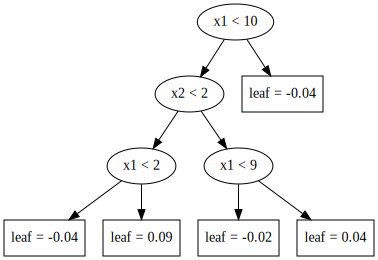

In [25]:
gz = Digraph()

gz.node("t1","x1 < 10")
gz.node("t1_1L","x2 < 2")
gz.node("t1_1R","leaf = -0.04", shape="box")
gz.node("t1_2L","x1 < 2")
gz.node("t1_2R","x1 < 9")
gz.node("t1_3L1","leaf = -0.04", shape='box')
gz.node("t1_3R1","leaf = 0.09", shape='box')
gz.node("t1_3L2","leaf = -0.02", shape='box')
gz.node("t1_3R2","leaf = 0.04", shape='box')


gz.edge("t1","t1_1L")
gz.edge("t1","t1_1R")
gz.edge("t1_1L","t1_2L")
gz.edge("t1_1L","t1_2R")
gz.edge("t1_2L","t1_3L1")
gz.edge("t1_2L","t1_3R1")
gz.edge("t1_2R","t1_3L2")
gz.edge("t1_2R","t1_3R2")

gz

## 5 推荐阅读
基本原理：

- Tianqi Chen 2014：[Introduction to Boosted Tree](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)
- [XGBoost、GBDT超详细推导](https://cloud.tencent.com/developer/article/1513111)
- [xgboost原理分析以及实践](https://blog.csdn.net/qq_22238533/article/details/79477547)
- 网络课程：[Xgboost提升算法](https://www.youtube.com/playlist?list=PLGmd9-PCMLhb5SGkPHKpAWujeXONmfvaQ)

深入分析：

- [一文读懂机器学习大杀器XGBoost原理](https://zhuanlan.zhihu.com/p/40129825)
- [XGBoost之类别特征的处理](https://www.biaodianfu.com/categorical-features.html)
- [灵魂拷问，你看过Xgboost原文吗？](https://zhuanlan.zhihu.com/p/86816771)

实践部分：

- Python Demo：[XGBoost: How it works, with an example.](https://www.youtube.com/watch?v=OQKQHNCVf5k)
- [Python One Hot Encoding with SciKit Learn](http://www.insightsbot.com/python-one-hot-encoding-with-scikit-learn)
- 训练Fasion Minst：[From Zero to Hero in XGBoost Tuning](https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58)

## 6 附录：Logistic Regression

$$y=\frac{1}{1+e^{-x}}$$

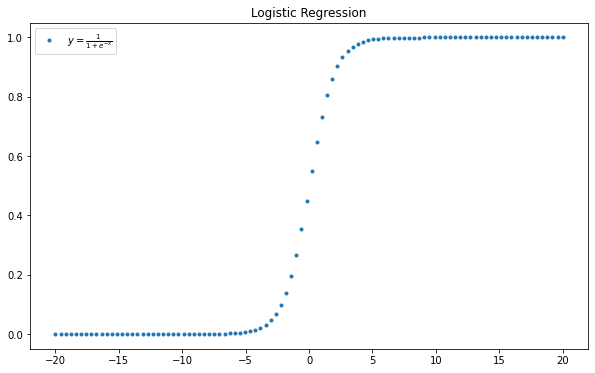

In [26]:
Xs = np.linspace(-20, 20, 100)

def lgstrg(x):
    return 1/(1+np.exp(-x))

plt.figure(figsize=(10, 6))
plt.plot(Xs, lgstrg(Xs), '.', label=r'$y=\frac{1}{1+e^{-x}}$')
plt.title(r'Logistic Regression')
plt.legend()
plt.show()